In [10]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import FocalLoss, f1
from dark import *

In [11]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [12]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())

# def open_image4d(path:PathOrStr)->Image:
#     '''open RGBA image from a single 4-channel file
#     return: numpy array [4, sz, sz]'''
#     path=str(path)
#     flags = cv2.IMREAD_UNCHANGED
#     im = cv2.imread(path+ '.png', flags)
#     return Image(Tensor(np.rollaxis(im, 2, 0)/255).float())


In [13]:
fname = train_names[0]

In [14]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 16.6 ms, sys: 4.05 ms, total: 20.6 ms
Wall time: 34.1 ms


In [15]:
im.shape

torch.Size([4, 512, 512])

In [16]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [17]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, label_delim=' ', fn_col=0, label_col=1)
test_fnames, _ = _df_to_fns_labels(sample_sub, fn_col=0, label_col=1)

In [18]:
classes = uniqueify(np.concatenate(labels))

In [19]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [20]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [32]:
def get_data(sz=64, bs=64, is_test=False):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)


In [22]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [23]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [24]:
# from torch.utils.data.sampler import WeightedRandomSampler
# wrs = WeightedRandomSampler(weight, len(weight))

In [25]:
arch = dark_small()

In [38]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1])
    if focal: learn.loss_func=FocalLoss()
    if fp16: learn.to_fp16();
    learn.load('dk_small_64')
    return learn

In [39]:
data = get_data(128, 64, True)
learn = get_learner(data, focal=True, fp16=True)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


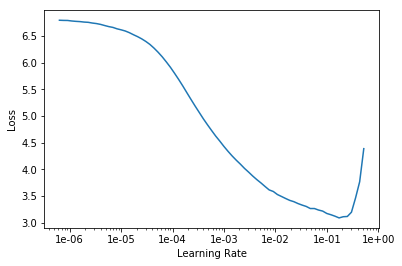

In [55]:
learn.lr_find()
learn.recorder.plot()

In [34]:
lr = 1e-3

In [ ]:
%time learn.fit_one_cycle(10, lr/10)

epoch,train_loss,valid_loss,accuracy_thresh,f1


In [24]:
learn.save('dk_small_64')

In [23]:
%time learn.fit_one_cycle(6, lr/10)

Total time: 05:54
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.869015    0.909732    0.958083         0.485891  (00:58)
2      0.873271    0.920182    0.957497         0.499596  (00:58)
3      0.877803    0.907295    0.958072         0.487138  (00:59)
4      0.864485    0.904712    0.958193         0.499805  (00:59)
5      0.864348    0.904011    0.958164         0.501027  (00:59)
6      0.853259    0.904064    0.958072         0.492853  (00:59)

CPU times: user 3min 27s, sys: 2min 20s, total: 5min 48s
Wall time: 5min 54s


# Validation and Preds

In [73]:
learn.data.test_dl.add_tfm(to_half)
learn.data.valid_dl.add_tfm(to_half)

In [70]:
p,t = learn.get_preds(is_test=True)

In [71]:
p.shape

torch.Size([11702, 28])

In [74]:
p_v, t_v = learn.get_preds()

In [75]:
def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+1e-7)
    rec = TP/(y_true.sum(1)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

In [78]:
p_v_s = p_v.sigmoid()

In [81]:
f1(p_v, t_v)

tensor(0.6248)

In [82]:
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [83]:
f1_np(p_v_np, t_v_np)

0.6248206935302782

In [84]:
def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

In [88]:
f1_n(p_v_np, t_v_np, 0.4, 0)

0.622869969677993

In [94]:
def find_thresh(y_pred, y_true):
    ths = []
    for i in range(p_v_np.shape[1]):
        aux = []
        for th in np.linspace(0,1,100):
            aux += [f1_n(p_v_np, t_v_np, th, i)]
        ths += [np.array(aux).argmax()/100]
    return np.array(ths)

In [96]:
ths = find_thresh(p_v_np, t_v_np)

In [99]:
ths

array([0.99, 0.41, 0.3 , 0.42, 0.33, 0.37, 0.59, 0.39, 0.3 , 0.36, 0.62, 0.53, 0.31, 0.6 , 0.59, 0.46, 0.41, 0.33,
       0.64, 0.39, 0.53, 0.36, 0.26, 0.32, 0.16, 0.38, 0.04, 0.11])

In [100]:
f1_np(p_v_np, t_v_np, ths)

0.6890822265523219

# Sub File

In [102]:
preds = to_np(p.sigmoid())
threshold = ths
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [103]:
res

array(['2', '5 25', '0 5 25 21', '0 25', ..., '0 25 19', '7', '1', '0 25 23'], dtype='<U25')

In [104]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('my_submission.csv', index=False)

In [105]:
#fix indexing
f1 = pd.read_csv('sample_submission.csv')
f1.drop('Predicted', axis=1, inplace=True)
f2 = pd.read_csv('my_submission.csv')
f1 = f1.merge(f2, left_on='Id', right_on='Id', how='outer')
f1.to_csv('my_new_submission.csv', index=False)